In [1]:
from collections import namedtuple
from dataclasses import dataclass
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

tf.version.VERSION

2023-01-21 23:28:03.731665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.11.0'

In [2]:
@dataclass
class Config:
    # anchors
    INPUT_SIZE = [320, 320]
    FEATURE_SIZES = [40, 20, 10, 5, 3]
    AREAS = [side**2 for side in [8, 32, 64, 128, 160]]
    ASPECT_RATIOS = [1.0, 0.5, 2.0]
    SCALES = [1.0, 1.33, 1.66]
    POSITIVE_IOU = 0.5
    NEGATIVE_IOU = 0.3
    BOX_VARIANCE = [0.1, 0.1, 0.2, 0.2]
    
    # augmentation
    RANDOM_CROP_PERCENT = 0.1
    
    # training
    DROPOUT = 0.1
    ALPHA = 0.25
    GAMMA = 2.0
    BATCH_SIZE = 32
    BUFFER_SIZE = 100
    NUM_CLASSES = 80
    TOP_K_NEGATIVE_LOSS = 100
    LEARNING_RATES = [2.5e-06, 0.0000625, 0.000625, 0.00025, 0.000125, 2.5e-05]
    LEARNING_RATE_BOUNDARIES = [125, 250, 500, 76000, 155000]
    EPOCHS = 100
    
    # output
    MAX_OUTPUT_SIZE = 100
    OUTPUT_IOU_THRESHOLD = 0.02
    OUTPUT_SCORE_THRESHOLD = 0.9



config = Config()

# Create Anchor boxes

In [3]:
class AnchorBoxGenerator(object):
    def __init__(self, config):
        self.config = config
    
    def generate(self):
        anchors = []
        for f, feature_size in enumerate(self.config.FEATURE_SIZES):
            grid_width = config.INPUT_SIZE[1] / feature_size
            grid_height = config.INPUT_SIZE[0] / feature_size
            area = config.AREAS[f]
            for i in range(feature_size):
                for j in range(feature_size):
                    cx = j * grid_width + 0.5 * grid_width
                    cy = i * grid_height + 0.5 * grid_height
                    for scale in config.SCALES:
                        for aspect_ratio in config.ASPECT_RATIOS:
                            h = np.sqrt(area / aspect_ratio)
                            w = area / h
                            h *= scale
                            w *= scale
                            anchors.append([cx, cy, w, h])
        return np.array(anchors)


anchor_generator = AnchorBoxGenerator(config)
anchors = anchor_generator.generate()
anchor_tensor = tf.constant(anchors, tf.float32)
print(anchor_tensor.shape)
print(anchor_tensor)

(19206, 4)
tf.Tensor(
[[  4.         4.         8.         8.      ]
 [  4.         4.         5.656854  11.313708]
 [  4.         4.        11.313708   5.656854]
 ...
 [266.66666  266.66666  265.6      265.6     ]
 [266.66666  266.66666  187.80756  375.6151  ]
 [266.66666  266.66666  375.6151   187.80756 ]], shape=(19206, 4), dtype=float32)


2023-01-21 23:28:06.276640: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


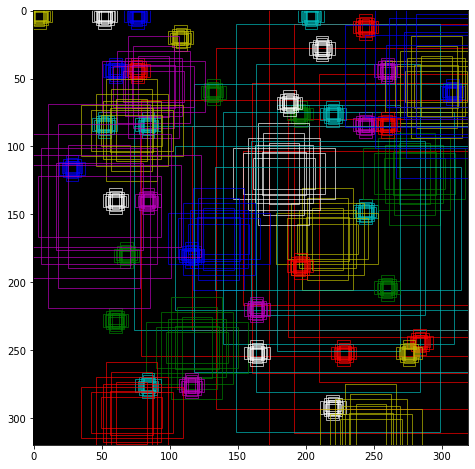

In [4]:
def show_random_anchors(anchors, config, count=50):
    group_size = len(config.SCALES) * len(config.ASPECT_RATIOS)
    max_index = len(anchors) // group_size
    
    empty_image = np.zeros(shape=[*config.INPUT_SIZE, 3], dtype=np.uint8)
    plt.imshow(empty_image)
    ax = plt.gca()
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'w']
    for i, c in enumerate(range(count)):
        index = np.random.randint(0, max_index) * group_size
        for offset in range(group_size):
            cx, cy, w, h = anchors[index+offset, ...]
            x = cx - w / 2
            y = cy - h / 2
            color = colors[i % len(colors)]
            rect = patches.Rectangle((x, y), w, h, facecolor='none', edgecolor=color, alpha=0.66)
            ax.add_patch(rect)


plt.figure(figsize=(8, 8))
show_random_anchors(anchors, config)
plt.show()

# Input Pipeline

In [5]:
coco2014 = tfds.load('coco/2014')
coco2017 = tfds.load('coco/2017')

In [6]:
coco2014['train'].cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=82783>

In [7]:
coco2017['train'].cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=118287>

In [8]:
CLASS_NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
    'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

## Visualize Data

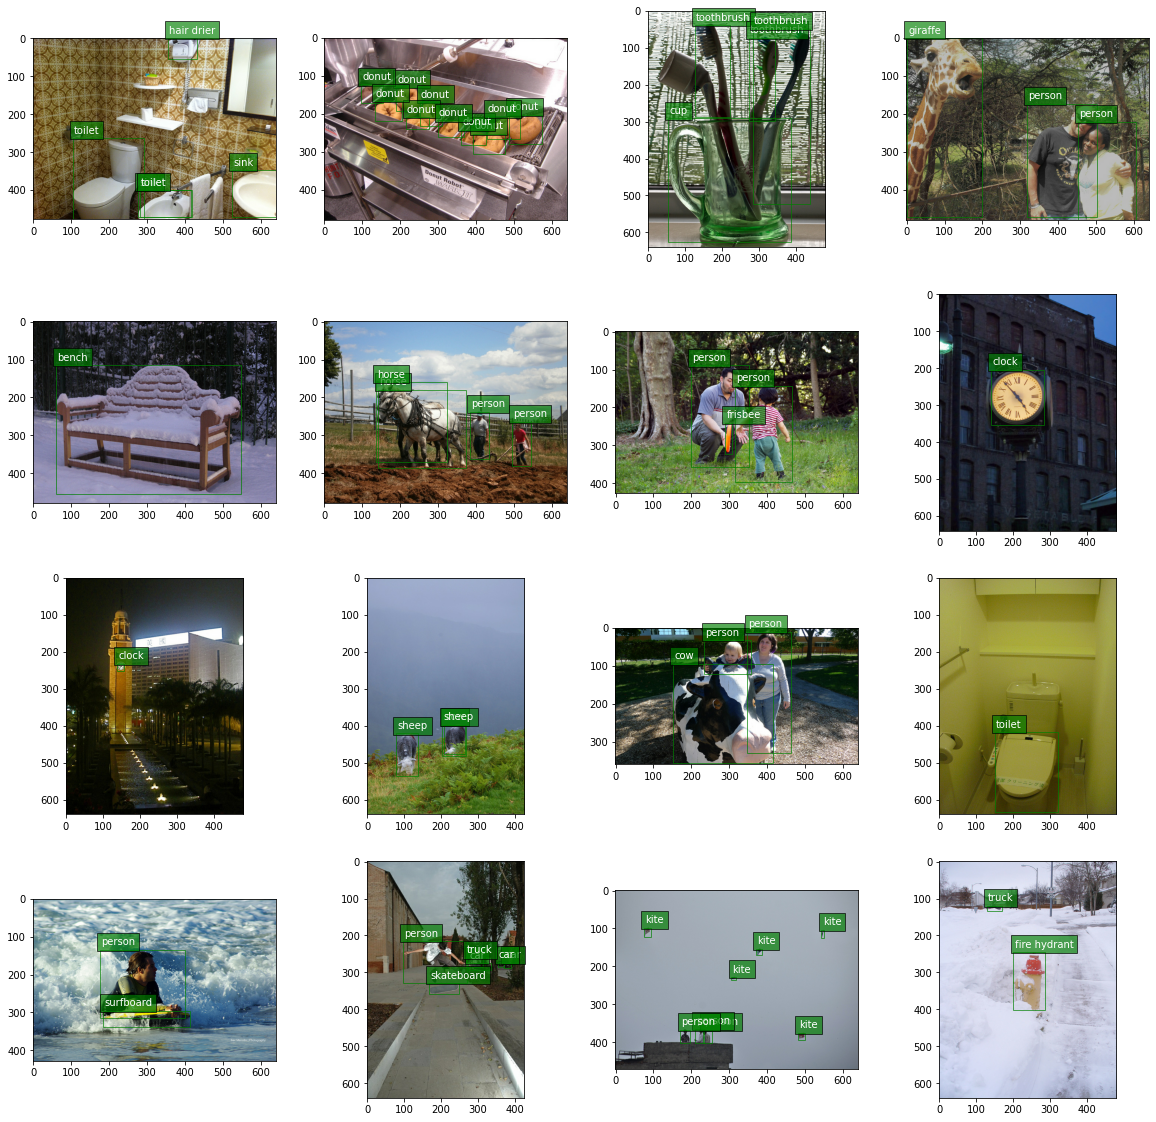

In [9]:
def show_data_pair(image, bbox, label):
    plt.imshow(image)
    ax = plt.gca()
    h, w = image.shape[:2]
    for i, bbox in enumerate(bbox.numpy()):
        ymin = bbox[0] * h
        xmin = bbox[1] * w
        ymax = bbox[2] * h
        xmax = bbox[3] * w
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                 facecolor='none', edgecolor='g', alpha=0.66)
        ax.add_patch(rect)
        
        c = label[i].numpy()
        plt.text(xmin+3, ymin-13, CLASS_NAMES[c], color='w', bbox=dict(facecolor='g', alpha=0.66))


def show_ds(ds):
    plt.figure(figsize=(20, 20))
    for i, entry in enumerate(ds):
        if i >= 16:
            break
        plt.subplot(4, 4, i+1)
        show_data_pair(entry['image'], entry['objects']['bbox'], entry['objects']['label'])


show_ds(coco2014['train'])
plt.show()

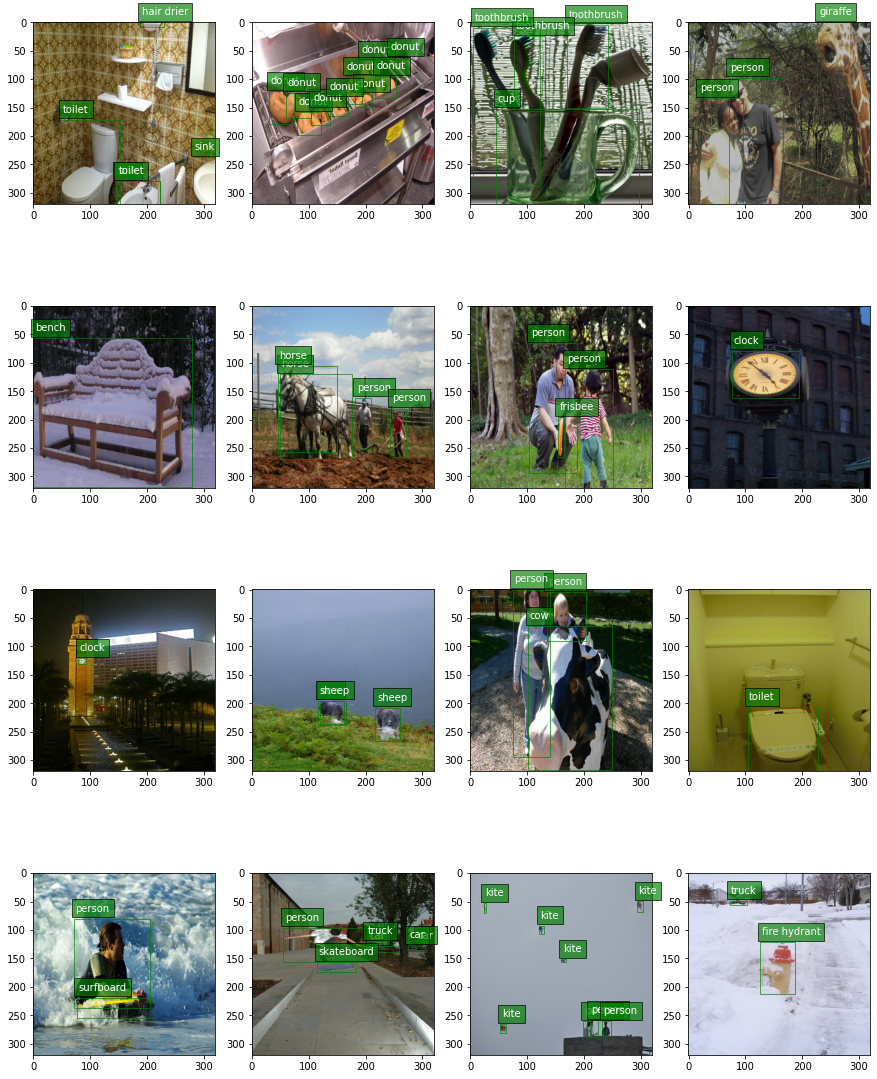

In [10]:
def random_flip(image, bbox):
    flip = tf.cast(tf.greater_equal(tf.random.uniform((), 0.0, 1.0), 0.5), tf.bool)
    image = tf.where(flip, tf.image.flip_left_right(image), image)
    new_x1 = tf.where(flip, 1.0 - bbox[:, 1], bbox[:, 1])
    new_x2 = tf.where(flip, 1.0 - bbox[:, 3], bbox[:, 3])
    new_xmin = tf.minimum(new_x1, new_x2)
    new_xmax = tf.maximum(new_x1, new_x2)
    new_bbox = tf.stack([bbox[:, 0], new_xmin, bbox[:, 2], new_xmax], axis=1)
    return image, new_bbox


def random_crop(image, bbox, label):
    left = tf.random.uniform((), 0.0, config.RANDOM_CROP_PERCENT)
    right = tf.random.uniform((), 1.0-config.RANDOM_CROP_PERCENT, 1.0)
    top = tf.random.uniform((), 0.0, config.RANDOM_CROP_PERCENT)
    bottom = tf.random.uniform((), 1.0-config.RANDOM_CROP_PERCENT, 1.0)
    
    new_width = right - left
    new_height = bottom - top
    
    y1 = tf.clip_by_value((bbox[:, 0] - top) / new_height, 0, 1.0)
    x1 = tf.clip_by_value((bbox[:, 1] - left) / new_width, 0, 1.0)
    y2 = tf.clip_by_value((bbox[:, 2] - top) / new_height, 0, 1.0)
    x2 = tf.clip_by_value((bbox[:, 3] - left) / new_width, 0, 1.0)
    valid = tf.logical_and(tf.greater(x2 - x1, 0), tf.greater(y2 - y1, 0))

    new_bbox = tf.stack([y1, x1, y2, x2], axis=1)
    new_bbox = tf.boolean_mask(new_bbox, valid)
    new_label = tf.boolean_mask(label, valid)
    
    image_shape = tf.cast(tf.shape(image), tf.float32)
    left = tf.cast(left * image_shape[1], tf.int32)
    right = tf.cast(right * image_shape[1], tf.int32)
    top = tf.cast(top * image_shape[0], tf.int32)
    bottom = tf.cast(bottom * image_shape[0], tf.int32)
    image = image[top:bottom, left:right, :]
    return image, new_bbox, new_label


def random_jitter(image, bbox, label):
    image, bbox, label = random_crop(image, bbox, label)
    image, bbox = random_flip(image, bbox)
    image = tf.image.resize(image, config.INPUT_SIZE)
    return image, bbox, label


def test_augmentation(entry):
    image = entry['image']
    bbox = entry['objects']['bbox']
    label = entry['objects']['label']
    return random_jitter(image, bbox, label)


def show_example(ds):
    plt.figure(figsize=(15, 20))
    for i, example in enumerate(ds):
        if i >= 16:
            break
        image, bbox, label = example
        plt.subplot(4, 4, i+1)
        show_data_pair(image.numpy().astype(np.uint8), bbox, label)


example_ds = coco2014['train'].map(test_augmentation)
show_example(example_ds)

1.77 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


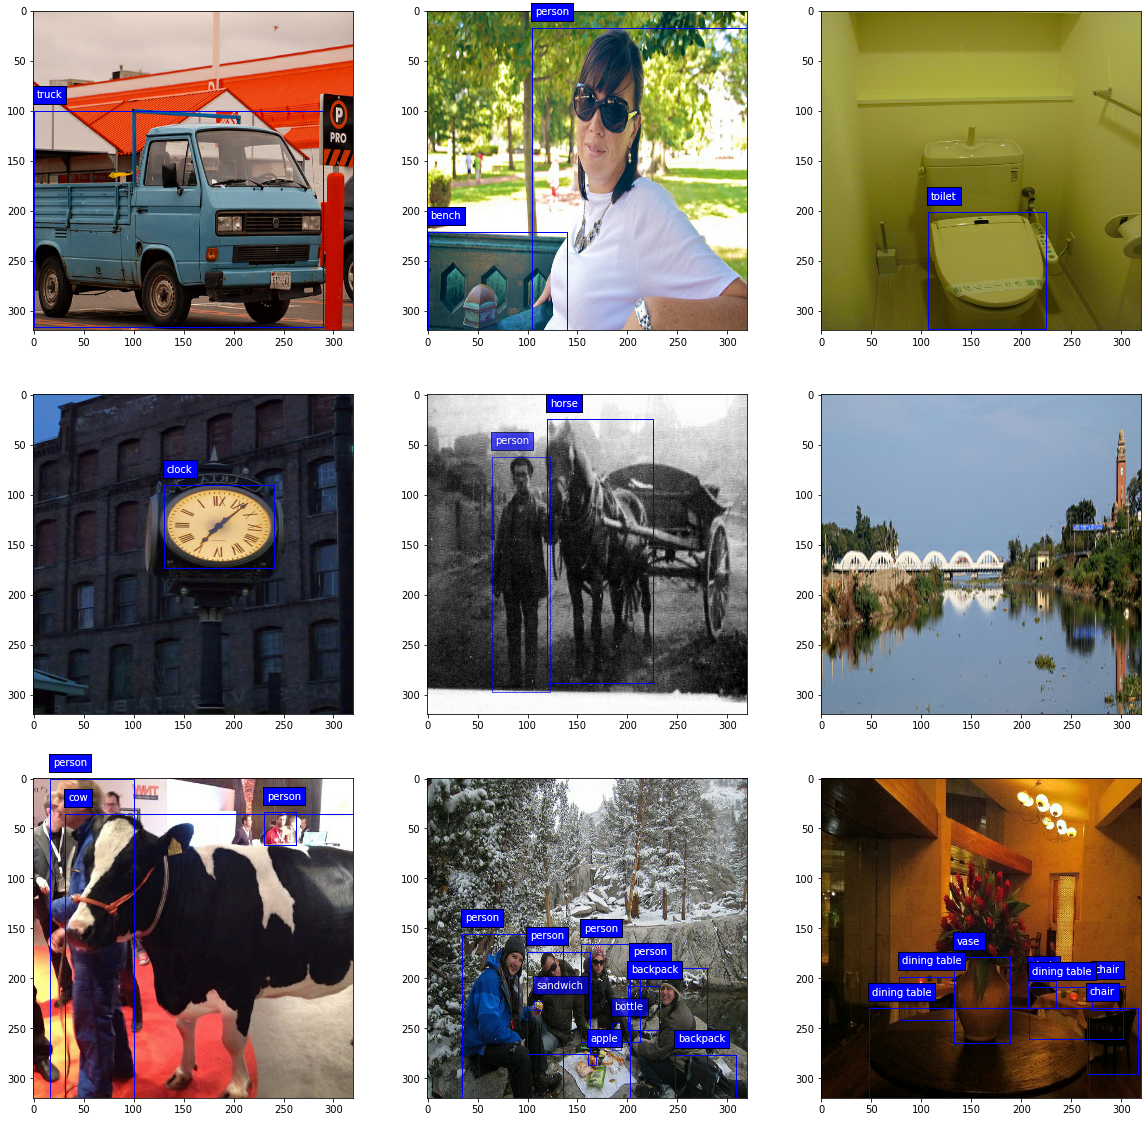

In [11]:
def convert_to_corners(boxes):
    """Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[cx, cy, width, height]`.

    Returns:
      converted boxes to [ymin, xmin, ymax, xmax]
    """
    y1 = boxes[:, 1] - boxes[:, 3] / 2
    x1 = boxes[:, 0] - boxes[:, 2] / 2
    y2 = boxes[:, 1] + boxes[:, 3] / 2
    x2 = boxes[:, 0] + boxes[:, 2] / 2
    return tf.stack([y1, x1, y2, x2], axis=-1)


def scale_bbox(bbox):
    y1 = bbox[:, 0] * config.INPUT_SIZE[0]
    x1 = bbox[:, 1] * config.INPUT_SIZE[1]
    y2 = bbox[:, 2] * config.INPUT_SIZE[0]
    x2 = bbox[:, 3] * config.INPUT_SIZE[1]
    return tf.stack([y1, x1, y2, x2], axis=-1)


def compute_box_target(anchor_boxes, matched_gt_boxes):
    cy = (matched_gt_boxes[:, 0] + matched_gt_boxes[:, 2]) / 2
    cx = (matched_gt_boxes[:, 1] + matched_gt_boxes[:, 3]) / 2
    h = matched_gt_boxes[:, 2] - matched_gt_boxes[:, 0]
    w = matched_gt_boxes[:, 3] - matched_gt_boxes[:, 1]
    box_target = tf.stack([
        cx - anchor_boxes[:, 0] / config.INPUT_SIZE[1],
        cy - anchor_boxes[:, 1] / config.INPUT_SIZE[0],
        tf.math.log(w / anchor_boxes[:, 2] * config.INPUT_SIZE[1]),
        tf.math.log(h / anchor_boxes[:, 3] * config.INPUT_SIZE[0]),
    ], axis=-1)
    return box_target


def IOU(anchors, bbox):
    """Computes pairwise IOU matrix for given two sets of boxes

    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.

    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    
    anchor_boxes = convert_to_corners(anchors)
    bounding_boxes = scale_bbox(bbox)
    top_left = tf.maximum(anchor_boxes[:, None, :2], bounding_boxes[:, :2])
    bot_right = tf.minimum(anchor_boxes[:, None, 2:], bounding_boxes[:, 2:])
    
    intersection = tf.math.maximum(bot_right-top_left, 0)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    anchor_area = anchors[:, 2] * anchors[:, 3]
    bbox_area = (bounding_boxes[:, 2] - bounding_boxes[:, 0]) * (bounding_boxes[:, 3] - bounding_boxes[:, 1])
    union_area = tf.maximum(anchor_area[:, None] + bbox_area - intersection_area, 1e-8)
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def match_anchors(anchors, bbox, cls_ids):
    if tf.shape(bbox)[0] == 0:
        box_target = tf.zeros_like(anchor_tensor, tf.float32)
        cls_target = tf.constant(-2, shape=[box_target.shape[0], 1], dtype=tf.float32)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label
        
    iou_matrix = IOU(anchors, bbox)
    max_iou = tf.reduce_max(iou_matrix, axis=1)
    matched_gt_idx = tf.argmax(iou_matrix, axis=1)
    positive_mask = tf.greater_equal(max_iou, config.POSITIVE_IOU)
    negative_mask = tf.less(max_iou, config.NEGATIVE_IOU)
    ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
    cls_ids = tf.cast(cls_ids, dtype=tf.float32)
    
    matched_gt_boxes = tf.gather(bbox, matched_gt_idx)
    box_target = compute_box_target(anchors, matched_gt_boxes)
    matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
    cls_target = tf.where(tf.logical_not(positive_mask), -1.0, matched_gt_cls_ids)
    cls_target = tf.where(ignore_mask, -2.0, cls_target)
    cls_target = tf.expand_dims(cls_target, axis=-1)
    label = tf.concat([box_target, cls_target], axis=-1)
    return label


def preprocess(training):
    def func(entry):
        image = entry['image']
        bbox = entry['objects']['bbox']
        label = entry['objects']['label']
        if training:
            image, bbox, label = random_jitter(image, bbox, label)
        else:
            image = tf.image.resize(image, config.INPUT_SIZE)
        label = match_anchors(anchor_tensor, bbox, label)
        return image, label
    return func


def show_image_label_pair(image, label, count=9):
    for i in range(count):
        plt.subplot(3, 3, i+1)
        ax = plt.gca()
        plt.imshow(image[i].numpy().astype(np.uint8))
        label_i = label[i]
        positive_mask = label_i[:, -1] >= 0
        positive_label = label_i[positive_mask]
        positive_anchors = anchors[positive_mask]
        for j, l in enumerate(positive_label):
            anchor = positive_anchors[j]
            cx = anchor[0] + l[0] * config.INPUT_SIZE[1]
            cy = anchor[1] + l[1] * config.INPUT_SIZE[0]
            w = np.exp(l[2]) * anchor[2]
            h = np.exp(l[3]) * anchor[3]
            x = cx - w / 2
            y = cy - h / 2
            rect = patches.Rectangle((x, y), w, h, facecolor='none', edgecolor='b', alpha=0.66)
            ax.add_patch(rect)
        
            c = l[-1].numpy().astype(np.int32)
            plt.text(x+3, y-13, CLASS_NAMES[c], color='w', bbox=dict(facecolor='b', alpha=0.66))


def test(ds):
    for i, entry in enumerate(ds):
        image, label = entry
        if i > 10:
            break


def show_example_training_pair(ds):
    plt.figure(figsize=(20, 20))
    for entry in ds:
        image, label = entry
        label_0 = label[0]
        # print(label_0[label_0[:, -1] >= 0])
        show_image_label_pair(image, label)
        break
    plt.show()


# train_ds1 = coco2014['train'].shuffle(config.BUFFER_SIZE).map(preprocess(True))
# train_ds2 = coco2017['train'].shuffle(config.BUFFER_SIZE).map(preprocess(True))
# train_ds = train_ds1.concatenate(train_ds2).batch(config.BATCH_SIZE)
train_ds = coco2014['train'].shuffle(config.BUFFER_SIZE).map(preprocess(True)).batch(config.BATCH_SIZE)

%timeit test(train_ds)
show_example_training_pair(train_ds)

In [12]:
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=2587>

In [13]:
# val_ds1 = coco2014['train'].shuffle(config.BUFFER_SIZE).map(preprocess(False))
# val_ds2 = coco2017['train'].shuffle(config.BUFFER_SIZE).map(preprocess(False))
# val_ds = val_ds1.concatenate(val_ds2).batch(config.BATCH_SIZE)
val_ds = coco2014['validation'].shuffle(config.BUFFER_SIZE).map(preprocess(False)).batch(config.BATCH_SIZE)

In [14]:
val_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=1266>

# Create Model

In [15]:
def conv(x, output_size, ksize, stride):
    x = keras.layers.DepthwiseConv2D(ksize, stride, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(output_size, 1, 1, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    return x


def output_conv(x, output_size):
    x = keras.layers.DepthwiseConv2D(3, 1, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(output_size, 1, 1, padding='same')(x)
    return x


def bounding_box_output(x):
    num_box_per_cell = len(config.ASPECT_RATIOS) * len(config.SCALES)
    size = x.shape[1]
    class_x = output_conv(x, num_box_per_cell * (config.NUM_CLASSES+1))
    class_x = keras.layers.Reshape([size*size*num_box_per_cell, config.NUM_CLASSES+1])(class_x)
    box_x = output_conv(x, num_box_per_cell * 4)
    box_x = keras.layers.Reshape([size*size*num_box_per_cell, 4])(box_x)
    output = keras.layers.Concatenate(axis=-1)([box_x, class_x])
    return output


def build_object_detection_model():
    mobilenetv3 = keras.applications.MobileNetV3Small(input_shape=[*config.INPUT_SIZE, 3], include_top=True)
    outputs = []
    layer_names = ['multiply_1', 'multiply_11', 'multiply_17']
    for layer_name in layer_names:
        x = mobilenetv3.get_layer(layer_name).output
        output = bounding_box_output(x)
        outputs.append(output)
        
    x = mobilenetv3.get_layer(layer_names[-1]).output
    feature1 = conv(x, 864, 3, 2)
    output = bounding_box_output(feature1)
    outputs.append(output)
    
    feature2 = conv(feature1, 1152, 3, 2)
    output = bounding_box_output(feature2)
    outputs.append(output)
    
    outputs = tf.concat(outputs, axis=1)
    model = keras.Model(inputs=mobilenetv3.inputs, outputs=[outputs])
    return model


keras.backend.clear_session()
model = build_object_detection_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 320, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 160, 160, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
class SSDLoss(keras.losses.Loss):
    def call(self, y_true, y_pred):
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        negative_mask = 1.0 - positive_mask
        loc_loss = tf.nn.sigmoid_cross_entropy_with_logits(positive_mask, y_pred[:, :, 4])
        
        num_positive = tf.reduce_sum(positive_mask)
        pos_obj_loss = tf.math.divide_no_nan(config.ALPHA * tf.reduce_sum(loc_loss * positive_mask), num_positive)
        num_negative = tf.reduce_sum(negative_mask)
        neg_obj_loss = tf.math.divide_no_nan((1.0 - config.ALPHA) * tf.reduce_sum(loc_loss * negative_mask), num_negative)
        obj_loss = pos_obj_loss + neg_obj_loss
        
        box_error = tf.square(y_true[:, :, :4] - y_pred[:, :, :4])
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_error * tf.expand_dims(positive_mask, axis=-1)), num_positive)
        
        class_true = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=config.NUM_CLASSES,
            dtype=tf.float32)
        
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(class_true, y_pred[:, :, 5:])
        class_loss = tf.math.divide_no_nan(tf.reduce_sum(softmax_loss * positive_mask), num_positive)

        return obj_loss + box_loss + class_loss
        


class PositiveBoxAccuracy(keras.metrics.Metric):
    def __init__(self, name='positive_box_accuracy', **kwargs):
        super(PositiveBoxAccuracy, self).__init__(name=name, **kwargs)
        self.positive_prediction = self.add_weight(name='positive_prediction', initializer='zeros')
        self.positive_count = self.add_weight(name='positive_count', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        class_label = y_true[:, :, 4]
        positive_mask = tf.cast(tf.greater(class_label, -1.0), tf.float32)
        negative_mask = tf.cast(tf.equal(class_label, -2.0), tf.float32)
        
        class_prediction = y_pred[:, :, 5:]
        prediction = tf.argmax(class_prediction, axis=-1)
        positive_prediction = tf.cast(tf.equal(prediction, tf.cast(class_label, tf.int64)), tf.float32) * positive_mask
        
        self.positive_prediction.assign_add(tf.reduce_sum(positive_prediction))
        self.positive_count.assign_add(tf.reduce_sum(positive_mask))
    
    def result(self):
        return self.positive_prediction / self.positive_count


def train(model):
    learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=config.LEARNING_RATE_BOUNDARIES, values=config.LEARNING_RATES)
    optimizer = keras.optimizers.Adam(learning_rate_fn)
    loss = SSDLoss()
    metrics = [PositiveBoxAccuracy()]
    callbacks = [
        keras.callbacks.ModelCheckpoint('./object_detection_coco/object_detection_coco.h5')
    ]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model.fit(train_ds, epochs=config.EPOCHS, callbacks=callbacks, verbose=True)


def test(model):
    for entry in train_ds:
        images, labels = entry
        pred = model(images)
        loss_fn = SSDLoss()
        loss = loss_fn(labels, pred)
        print(loss)
        break


history = train(model)

# test(model)

Epoch 1/100
2587/2587 [==============================] - 366s 130ms/step - loss: 3.0366 - positive_box_accuracy: 0.4350
Epoch 2/100
2587/2587 [==============================] - 338s 131ms/step - loss: 1.6516 - positive_box_accuracy: 0.6214
Epoch 3/100
2587/2587 [==============================] - 336s 130ms/step - loss: 1.4392 - positive_box_accuracy: 0.6656
Epoch 4/100
2587/2587 [==============================] - 331s 128ms/step - loss: 1.3215 - positive_box_accuracy: 0.6901
Epoch 5/100
2587/2587 [==============================] - 331s 128ms/step - loss: 1.2442 - positive_box_accuracy: 0.7077
Epoch 6/100
2587/2587 [==============================] - 335s 129ms/step - loss: 1.1873 - positive_box_accuracy: 0.7205
Epoch 7/100
2587/2587 [==============================] - 334s 129ms/step - loss: 1.1354 - positive_box_accuracy: 0.7331
Epoch 8/100
2587/2587 [==============================] - 332s 128ms/step - loss: 1.0938 - positive_box_accuracy: 0.7435
Epoch 9/100
2587/2587 [=================

# Non-Max Suppression and Prediction

In [17]:
def create_inference_model(model):
    def pad_outputs(output):
        output_size = tf.shape(output)[0]
        padded = tf.cond(output_size < config.MAX_OUTPUT_SIZE,
                         lambda: tf.pad(output, [[0, config.MAX_OUTPUT_SIZE-output_size], [0, 0]]),
                         lambda: output)
        return padded
    
    def non_max_suppress(model_output):
        """
        input: [num_bounding_boxes, 4 + num_classes]
        output:
            selected_boxes: [max_output_size, 4]
            selected_scores: [max_output_size, 1]
            selected_classes: [max_output_size, 1]
        """
        
        cx = model_output[:, 0] * config.INPUT_SIZE[1] + anchor_tensor[:, 0]
        cy = model_output[:, 1] * config.INPUT_SIZE[0] + anchor_tensor[:, 1]
        w = tf.exp(model_output[:, 2]) * anchor_tensor[:, 2]
        h = tf.exp(model_output[:, 3]) * anchor_tensor[:, 3]
        boxes = tf.stack([cy - h / 2, cx - w / 2, cy + h / 2, cx + w / 2], axis=-1)
        class_output = tf.nn.softmax(model_output[:, 5:])
        # scores = tf.reduce_max(class_output, axis=-1)
        scores = tf.nn.sigmoid(model_output[:, 4])
        cls_ids = tf.argmax(class_output, axis=-1)
        
        selected_indices = tf.image.non_max_suppression(
            boxes,
            scores,
            config.MAX_OUTPUT_SIZE,
            iou_threshold=config.OUTPUT_IOU_THRESHOLD,
            score_threshold=config.OUTPUT_SCORE_THRESHOLD)
        
        selected_boxes = tf.gather(boxes, selected_indices)
        selected_scores = tf.expand_dims(tf.gather(scores, selected_indices), axis=-1)
        selected_classes = tf.expand_dims(tf.gather(cls_ids, selected_indices), axis=-1)
        
        padded_boxes = pad_outputs(selected_boxes)
        padded_scores = pad_outputs(selected_scores)
        padded_classes = pad_outputs(selected_classes)
        return padded_boxes, padded_scores, padded_classes
    
    def post_process(model_output):
        return tf.map_fn(non_max_suppress, model_output,
                         fn_output_signature=(tf.float32, tf.float32, tf.int64))
    
    x = model.outputs[0]
    inference_outputs = keras.layers.Lambda(post_process)(x)
    model = keras.Model(inputs=model.inputs, outputs=inference_outputs)
    return model


inference_model = create_inference_model(model)
inference_model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 320, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 160, 160, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                            

1/1 [==============================] - 1s 1s/step


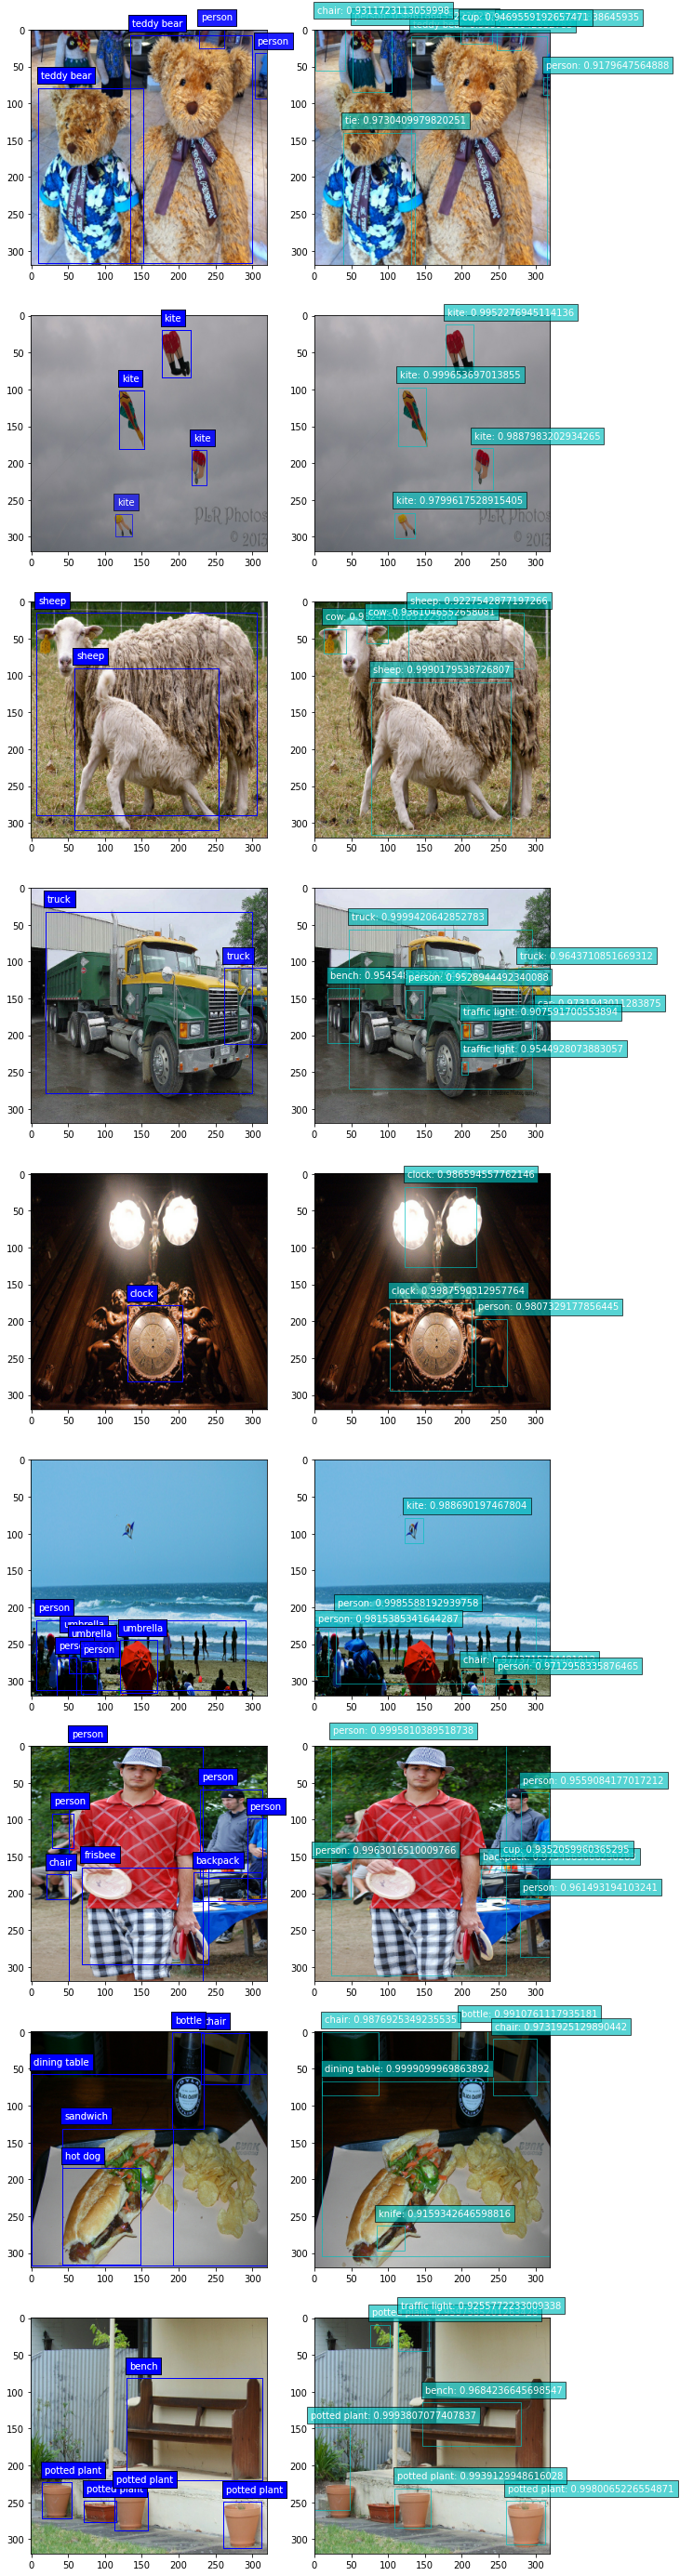

In [18]:
def show_true_label(image, label):
    plt.imshow(image)
    ax = plt.gca()
    positive_mask = label[:, -1] >= 0
    positive_label = label[positive_mask]
    positive_anchors = anchors[positive_mask]
    for j, l in enumerate(positive_label):
        anchor = positive_anchors[j]
        cx = anchor[0] + l[0] * config.INPUT_SIZE[1]
        cy = anchor[1] + l[1] * config.INPUT_SIZE[0]
        w = np.exp(l[2]) * anchor[2]
        h = np.exp(l[3]) * anchor[3]
        x = cx - w / 2
        y = cy - h / 2
        rect = patches.Rectangle((x, y), w, h, facecolor='none', edgecolor='b', alpha=0.66)
        ax.add_patch(rect)

        c = l[-1].numpy().astype(np.int32)
        plt.text(x+3, y-13, CLASS_NAMES[c], color='w', bbox=dict(facecolor='b', alpha=0.66))


def show_prediction(image, boxes, scores, class_ids):
    plt.imshow(image)
    ax = plt.gca()
    for j, score in enumerate(scores):
        if score[0] == 0:
            break
        
        y1 = boxes[j, 0]
        x1 = boxes[j, 1]
        y2 = boxes[j, 2]
        x2 = boxes[j, 3]
        w = x2 - x1
        h = y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, facecolor='none', edgecolor='c', alpha=0.66)
        ax.add_patch(rect)
        
        c = class_ids[j, 0].astype(np.int32)
        label_text = f"{CLASS_NAMES[c]}: {score[0]}"
        plt.text(x1+3, y1-13, label_text, color='w', bbox=dict(facecolor='c', alpha=0.66))


def test_inference(ds, inference_model, count=9):
    plt.figure(figsize=(10, 50))
    for entry in ds:
        image, label = entry
        boxes, scores, class_ids = inference_model.predict(image)
        for i in range(count):
            plt.subplot(count, 2, i*2+1)
            img = image[i].numpy().astype(np.uint8)
            show_true_label(img, label[i])
            plt.subplot(count, 2, i*2+2)
            show_prediction(img, boxes[i], scores[i], class_ids[i])
        break
    plt.show()


test_inference(val_ds, inference_model)

In [19]:
# inference_model.save('object_detection_coco')
tf.saved_model.save(inference_model, 'object_detection_coco_v2')

INFO:tensorflow:Assets written to: object_detection_coco_v2/assets


INFO:tensorflow:Assets written to: object_detection_coco_v2/assets
